In [22]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [23]:
# Read data

folder_fields = "/home/anais/Alexandre/data/Calibration_top_grey/muDIC"

frames_true = np.load(os.path.join(folder_fields, "frames.npy"))
coords = np.load(os.path.join(folder_fields, "coords.npy"))
strain = np.load(os.path.join(folder_fields, "true_strain.npy"))

with open(os.path.join(folder_fields, 'params.txt')) as file:
    params = file.read()

## Visualization

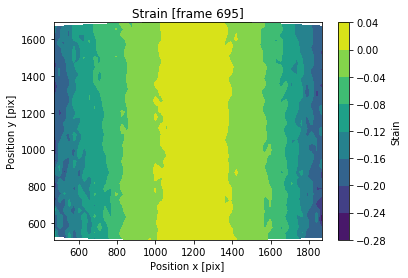

In [24]:
# Plot one frame

frame = -1
frame_true = frames_true[frame]

x = coords[0,0,:,:,frame]
y = coords[0,1,:,:,frame]

strain_toPlot = strain[0,0,0,:,:,frame]

fig, ax = plt.subplots()
ax.set_title(f"Strain [frame {frame_true}]")

im = ax.contourf(x, y, strain_toPlot)
fig.colorbar(im, ax=ax, label="Stain")

ax.set_xlabel('Position x [pix]')
ax.set_ylabel('Position y [pix]')

plt.show()

140 frames


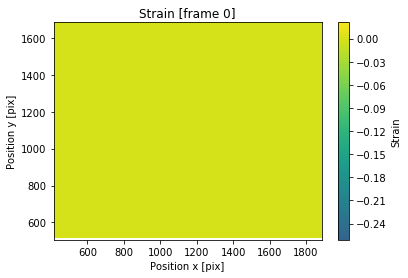

In [25]:
# Plot animation

nbFrames = coords.shape[-1]
frame_start = -1

fig, ax = plt.subplots()

# Set labels
ax.set_title(f"Strain [frame {frames_true[frame_start]}]")
ax.set_xlabel('Position x [pix]')
ax.set_ylabel('Position y [pix]')

# Set bounds
xbounds = coords[0,0,:,0,:].min(), coords[0,0,:,0,:].max()
ybounds = coords[0,1,:,0,:].min(), coords[0,1,0,:,:].max()
ax.set_xbound(*xbounds)
ax.set_ybound(*ybounds)

# Set static cmap
vmin, vmax = strain[0,0,0,:,:,1:].min(), strain[0,0,0,:,:,1:].max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('viridis')
n_levels = 100

# Plot last frame
x = coords[0,0,:,:,frame_start]
y = coords[0,1,:,:,frame_start]
strain_toPlot = strain[0,0,0,:,:,frame_start]

cont = ax.contourf(x, y, strain_toPlot, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont, ax=ax, label="Strain")


def update(frame):
    global cont

    x = coords[0,0,:,:,frame]
    y = coords[0,1,:,:,frame]
    strain_toPlot = strain[0,0,0,:,:,frame]
    
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact

    cont = plt.contourf(x, y, strain_toPlot, levels=n_levels, cmap=cmap, norm=norm)

    # Set limits and title
    ax.set_title(f"Strain [frame {frames_true[frame]}]")
    ax.set_xbound(*xbounds)
    ax.set_ybound(*ybounds)
    
    return cont

anim = animation.FuncAnimation(fig, update, frames=nbFrames, repeat=False, interval=100)
anim_html = HTML(anim.to_html5_video())

print(f"{nbFrames} frames")


In [26]:
# Display animation

print(type(anim_html))
anim_html

<class 'IPython.core.display.HTML'>


In [28]:
# Save animation

savepath = os.path.join(folder_fields, "animation_strain.html")
with open(savepath, 'w') as f:
    f.write(anim_html.data)

[5, 12, 19, 26, 32, 39, 46]


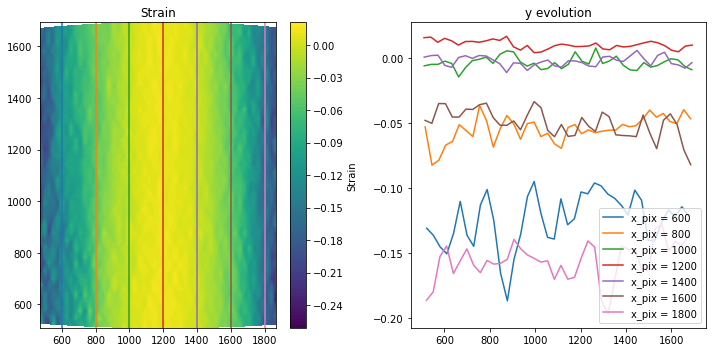

In [29]:
# Check invariance along y

frame = -1
x_pix_list = [600, 800, 1000, 1200, 1400, 1600, 1800]
#x_pix_list = [800, 1200, 1600]

x_frame = coords[0,0,:,:,frame]
y_frame = coords[0,1,:,:,frame]
strain_frame = strain[0,0,0,:,:,frame]

# Find nearest element for each y_pix
x_elem_list = []
for x_pix in x_pix_list:
    x_elem = np.argmin(np.abs(x_pix - x_frame[:,x_frame.shape[0]//2]))
    x_elem_list.append(x_elem)

# Plot ax1: contourf with lines; ax2: strain along y
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

ax1.set_title('Strain')
ax2.set_title('y evolution')

cont = ax1.contourf(x_frame, y_frame, strain_frame, cmap='viridis', levels=100)
fig.colorbar(cont, ax=ax1, label='Strain')

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

strains_evol_y = []
for i in range(len(x_pix_list)):
    x_pix, x_elem = x_pix_list[i], x_elem_list[i]
    color = color_cycle[i]

    ax1.axvline(x_pix, c=color)
    ax2.plot(y_frame[x_elem,:], strain_frame[x_elem,:], c=color, label=f"x_pix = {x_pix}")
    strains_evol_y.append(strain_frame[x_elem,:])

ax2.legend()

print(x_elem_list)
plt.show()


[5, 12, 19, 26, 32, 39, 46]


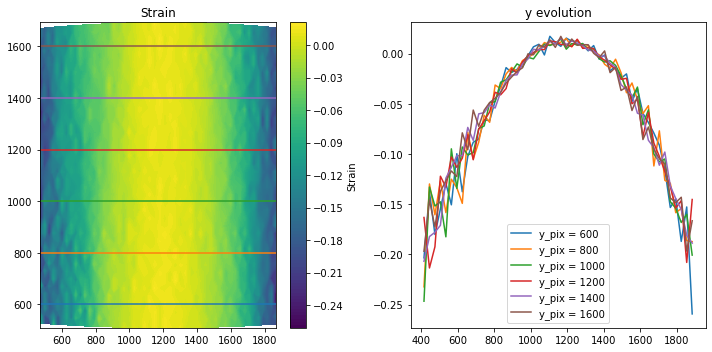

In [38]:
# Check evolution along x

frame = -1
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]
#y_pix_list = [800, 1200, 1600]

x_frame = coords[0,0,:,:,frame]
y_frame = coords[0,1,:,:,frame]
strain_frame = strain[0,0,0,:,:,frame]

x_0, y_0 = coords[0,0,:,:,0], coords[0,1,:,:,0]

# Find nearest element for each y_pix
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y_frame[y_frame.shape[0]//2,:]))
    y_elem_list.append(y_elem)

# Plot ax1: contourf with lines; ax2: strain along y
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)

ax1.set_title('Strain')
ax2.set_title('y evolution')

cont = ax1.contourf(x_frame, y_frame, strain_frame, cmap='viridis', levels=100)
fig.colorbar(cont, ax=ax1, label='Strain')

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

strain_evol_x = []
for i in range(len(y_pix_list)):
    y_pix, y_elem = y_pix_list[i], y_elem_list[i]
    color = color_cycle[i]

    ax1.axhline(y_pix, c=color)
    ax2.plot(x_0[:,y_elem], strain_frame[:,y_elem], c=color, label=f"y_pix = {y_pix}")
    strain_evol_x.append(strain_frame[:,y_elem])

ax2.legend()

print(x_elem_list)
plt.show()

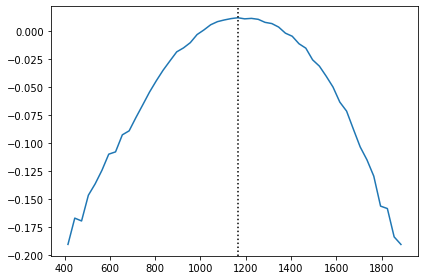

In [39]:
# Average strain along y

avg_x = x_0.mean(axis=1)
avg_strain = strain_frame.mean(axis=1)

argmax_strain = avg_strain.argmax()

fig, ax = plt.subplots(tight_layout=True)

ax.plot(avg_x, avg_strain)
ax.axvline(avg_x[argmax_strain], ls=':', c='k')


plt.show()

In [40]:
# Compute statistics

from scipy.stats import skew

avg_x_centered = avg_x - avg_x[argmax_strain]
skewness = skew(avg_strain)

print(f"Skewness: {skewness}")

Skewness: -0.5730165225886108


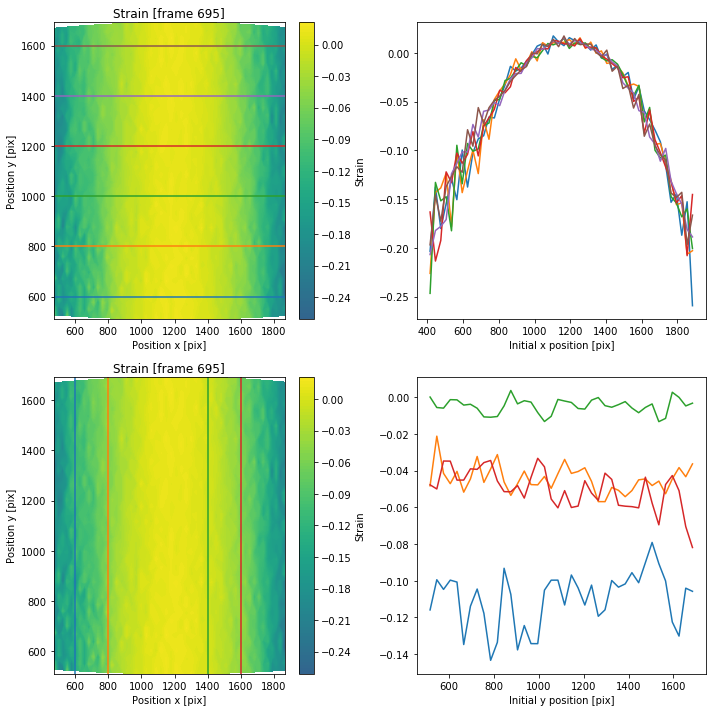

In [49]:
nbFrames = coords.shape[-1]
frame_start = -1

x_pix_list = [600, 800, 1400, 1600]
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]

# Find nearest elements
x_elem_list = []
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y_0[y_0.shape[0]//2,:]))
    y_elem_list.append(y_elem)
for x_pix in x_pix_list:
    x_elem = np.argmin(np.abs(x_pix - x_0[:,x_0.shape[0]//2]))
    x_elem_list.append(x_elem)


fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2, tight_layout=True)

# Set labels
for i in range(2):
    ax[i,0].set_title(f"Strain [frame {frames_true[frame_start]}]")
    ax[i,0].set_xlabel('Position x [pix]')
    ax[i,0].set_ylabel('Position y [pix]')
ax[0,1].set_xlabel('Initial x position [pix]')
ax[1,1].set_xlabel('Initial y position [pix]')

# Set bounds
xbounds = coords[0,0,:,0,:].min(), coords[0,0,:,0,:].max()
ybounds = coords[0,1,:,0,:].min(), coords[0,1,0,:,:].max()
for i in range(2):
    ax[i,0].set_xbound(*xbounds)
    ax[i,0].set_ybound(*ybounds)

# Set static cmap
vmin, vmax = strain[0,0,0,:,:,1:].min(), strain[0,0,0,:,:,1:].max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('viridis')
n_levels = 100

# Plot last frame
x = coords[0,0,:,:,frame_start]
y = coords[0,1,:,:,frame_start]
strain_toPlot = strain[0,0,0,:,:,frame_start]

# Contour plots
cont0 = ax[0,0].contourf(x, y, strain_toPlot, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont0, ax=ax[0,0], label="Strain")
cont1 = ax[1,0].contourf(x, y, strain_toPlot, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont1, ax=ax[1,0], label="Strain")

# Line sections
lines_y = [ax[0,1].plot(x_0[:,y_elem], strain_frame[:,y_elem], c=color, label=f"y_pix = {y_pix}")
           for y_elem, y_pix, color in zip(y_elem_list, y_pix_list, color_cycle)]
lines_x = [ax[1,1].plot(y_0[x_elem,:], strain_frame[x_elem,:], c=color, label=f"x_pix = {x_pix}")
           for x_elem, x_pix, color in zip(x_elem_list, x_pix_list, color_cycle)]

# Vert/Horiz lines
lines_horiz_y = [ax[0,0].axhline(y_pix, c=color) for y_pix, color in zip(y_pix_list, color_cycle)]
lines_vert_x = [ax[1,0].axvline(x_pix, c=color) for x_pix, color in zip(x_pix_list, color_cycle)]


140 frames


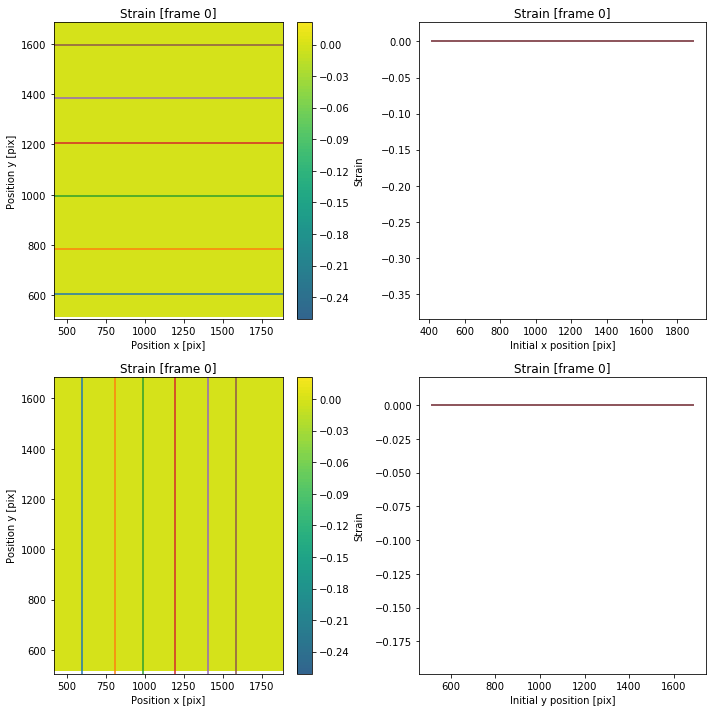

In [63]:
# Animation evolution strain with slices

nbFrames = coords.shape[-1]
frame_start = -1

x_pix_list = [600, 800, 1000, 1200, 1400, 1600]
y_pix_list = [600, 800, 1000, 1200, 1400, 1600]

# Find nearest elements
x_elem_list = []
y_elem_list = []
for y_pix in y_pix_list:
    y_elem = np.argmin(np.abs(y_pix - y_0[y_0.shape[0]//2,:]))
    y_elem_list.append(y_elem)
for x_pix in x_pix_list:
    x_elem = np.argmin(np.abs(x_pix - x_0[:,x_0.shape[0]//2]))
    x_elem_list.append(x_elem)


fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2, tight_layout=True)

# Set labels
for i in range(2):
    ax[i,0].set_title(f"Strain [frame {frames_true[frame_start]}]")
    ax[i,0].set_xlabel('Position x [pix]')
    ax[i,0].set_ylabel('Position y [pix]')
ax[0,1].set_xlabel('Initial x position [pix]')
ax[1,1].set_xlabel('Initial y position [pix]')

# Set bounds
xbounds_cont = coords[0,0,:,0,:].min(), coords[0,0,:,0,:].max()
ybounds_cont = coords[0,1,:,0,:].min(), coords[0,1,0,:,:].max()
for i in range(2):
    ax[i,0].set_xbound(*xbounds)
    ax[i,0].set_ybound(*ybounds)
ybounds_x = strain[0,0,0,x_elem_list,:,:].min(), strain[0,0,0,x_elem_list,:,:].max()
ybounds_y = strain[0,0,0,:,y_elem_list,:].min(), strain[0,0,0,:,y_elem_list,:].max()
ax[0,1].set_ybound(*ybounds_y)
ax[1,1].set_ybound(*ybounds_x)

# Set static cmap
vmin, vmax = strain[0,0,0,:,:,1:].min(), strain[0,0,0,:,:,1:].max()
norm = plt.Normalize(vmin, vmax)
cmap = plt.get_cmap('viridis')
n_levels = 100

# Plot last frame
x = coords[0,0,:,:,frame_start]
y = coords[0,1,:,:,frame_start]
strain_frame = strain[0,0,0,:,:,frame_start]

# Contour plots
cont0 = ax[0,0].contourf(x, y, strain_frame, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont0, ax=ax[0,0], label="Strain")
cont1 = ax[1,0].contourf(x, y, strain_frame, levels=n_levels, cmap=cmap, norm=norm)
fig.colorbar(cont1, ax=ax[1,0], label="Strain")

# Line sections
lines_y = [ax[0,1].plot(x_0[:,y_elem], strain_frame[:,y_elem], c=color, label=f"y_pix = {y_pix}")
           for y_elem, y_pix, color in zip(y_elem_list, y_pix_list, color_cycle)]
lines_x = [ax[1,1].plot(y_0[x_elem,:], strain_frame[x_elem,:], c=color, label=f"x_pix = {x_pix}")
           for x_elem, x_pix, color in zip(x_elem_list, x_pix_list, color_cycle)]

# Vert/Horiz lines
lines_horiz_y = [ax[0,0].axhline(y_pix, c=color) for y_pix, color in zip(y_pix_list, color_cycle)]
lines_vert_x = [ax[1,0].axvline(x_pix, c=color) for x_pix, color in zip(x_pix_list, color_cycle)]



def update(frame):
    global cont0, cont1, lines_y, lines_x, lines_horiz_y, lines_vert_x

    x = coords[0,0,:,:,frame]
    y = coords[0,1,:,:,frame]
    strain_frame = strain[0,0,0,:,:,frame]
    
    # Remove contours and lines
    for c in cont0.collections + cont1.collections:
        c.remove() 

    # Draw countourf
    cont0 = ax[0,0].contourf(x, y, strain_frame, levels=n_levels, cmap=cmap, norm=norm)
    cont1 = ax[1,0].contourf(x, y, strain_frame, levels=n_levels, cmap=cmap, norm=norm)
    
    # Plots curves
    for line, line_vert, x_elem in zip(lines_x, lines_vert_x, x_elem_list):
        line[0].set_ydata(strain_frame[x_elem,:])
        line_vert.set_data([x[x_elem,0], x[x_elem,0]], [0,1])
    for line, line_horiz, y_elem in zip(lines_y, lines_horiz_y, y_elem_list):
        line[0].set_ydata(strain_frame[:,y_elem])
        line_horiz.set_data([0,1], [y[0,y_elem],y[0,y_elem]])

    # Set limits and title
    for axi in ax.flatten():
        axi.set_title(f"Strain [frame {frames_true[frame]}]")
    for axi in ax[:,0]:
        axi.set_xbound(*xbounds)
        axi.set_ybound(*ybounds)
    ax[0,1].set_ybound(*ybounds_y)
    ax[1,1].set_ybound(*ybounds_x)
    
    return cont0, cont1

anim = animation.FuncAnimation(fig, update, frames=nbFrames, repeat=False, interval=100)
anim_html = HTML(anim.to_html5_video())

print(f"{nbFrames} frames")


In [64]:
# Display animation

anim_html

In [ ]:
# Save animation

savepath = os.path.join(folder_fields, "animation_strain_slices.html")
with open(savepath, 'w') as f:
    f.write(anim_html.data)